# Brown Dwarf Models

Modeling brown dwarfs is very similar to modeling thermal emission for exoplanets. The only difference is there is no stellar input!

In this tutorial you will learn:

1. How to turn that feature off 
2. Query a profile from the [Sonora Grid](https://zenodo.org/record/1309035#.Xo5GbZNKjGJ). Note, this is note necessary -- just convenient! 
3. Create a Brown Dwarf Spectrum 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import astropy.units as u

#picaso
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
#plotting
from bokeh.io import output_notebook

output_notebook()
from bokeh.plotting import show,figure

Loading BokehJS ...

Start with the same inputs as before

In [2]:
wave_range = [3,5]

opa = jdi.opannection(wave_range=wave_range)

bd = jdi.inputs(calculation='browndwarf')


In [3]:
# Note here that we do not need to provide case.star, since there is none! 
bd.gravity(gravity=100 , gravity_unit=u.Unit('m/s**2'))

#this is the integration setup that was used to compute the Sonora grid 
#take a look at Spherical Integration Tutorial to get a look at what these parameters do
bd.phase_angle(0)


## Download and Query from Sonora Profile Grid 

Download the profile files that are located in the [profile.tar file](https://zenodo.org/record/1309035#.Xo5GbZNKjGJ)

Once you untar the file you can set the file path below. You do not need to unzip each profile. `picaso` will do that upon read in. `picaso` will find the nearest neighbor and attach it to your class. 

In [4]:
#point to where you untared your sonora profiles
sonora_profile_db = '/data/sonora_profile/'
Teff = 900 
#this function will grab the gravity you have input above and find the nearest neighbor with the 
#note sonora chemistry grid is on the same opacity grid as our opacities (1060). 
bd.sonora(sonora_profile_db, Teff)

Note if you have added anything to your atmosphere profile (`bd.inputs['atmosphere']['profile']`), `sonora` function will overwrite it! Therefore, **make sure that you add new column fields after running sonora.** 

## Run Spectrum

In [5]:
df = bd.spectrum(opa, full_output=True)

## Convert to $F_\nu$ Units and Regrid

`PICASO` outputs the raw flux as: 

$$ F_\lambda ( \frac{erc}{cm^2 * sec * cm}) $$

Typical fluxes shown in several Brown Dwarf papers are: 

$$ F_\nu ( \frac{erc}{cm^2 * sec * Hz}) $$

Below is a little example of how to convert units. 

**NOTE**: Some people like to plot out `Eddington Flux`, $H_\nu$. This gets confusing as the units appear to be erg/cm2/s/Hz but you will notice a factor of four difference: 

$$H_\nu = \frac{F_\nu}{4}$$

In [6]:
x,y = df['wavenumber'], df['thermal'] #units of erg/cm2/s/cm

xmicron = 1e4/x

flamy = y*1e-8 #per anstrom instead of per cm
sp = jdi.psyn.ArraySpectrum(xmicron, flamy, 
                            waveunits='um', 
                            fluxunits='FLAM')   
sp.convert("um")
sp.convert('Fnu') #erg/cm2/s/Hz

x = sp.wave #micron
y= sp.flux #erg/cm2/s/Hz
df['fluxnu'] = y 
x,y = jdi.mean_regrid(1e4/x, y, R=300) #wavenumber, erg/cm2/s/Hz
df['regridy'] =  y
df['regridx'] = x

## Compare with Sonora Grid

The corresponding spectra are also available at the same link above. `PICASO` doesn't provide query functions
for this. So if you want to compare, you will have to read in the files as is done below

In [7]:
son = pd.read_csv('sp_t900g100nc_m0.0',delim_whitespace=True, 
                 skiprows=3,header=None,names=['w','f'])
sonx, sony =  jdi.mean_regrid(1e4/son['w'], son['f'], newx=x)

In [8]:
show(jpi.spectrum([x]*2,[df['regridy'], sony], legend=['PICASO', 'Sonora']
                  ,plot_width=800,x_range=wave_range,y_axis_type='log'))


## Thermal Contribution Function 

Contribution functions give us an understanding of where pressures flux is being emitted (e.g. [Lothringer et al 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aadd9e#apjaadd9es3-3-1) Figure 12) 

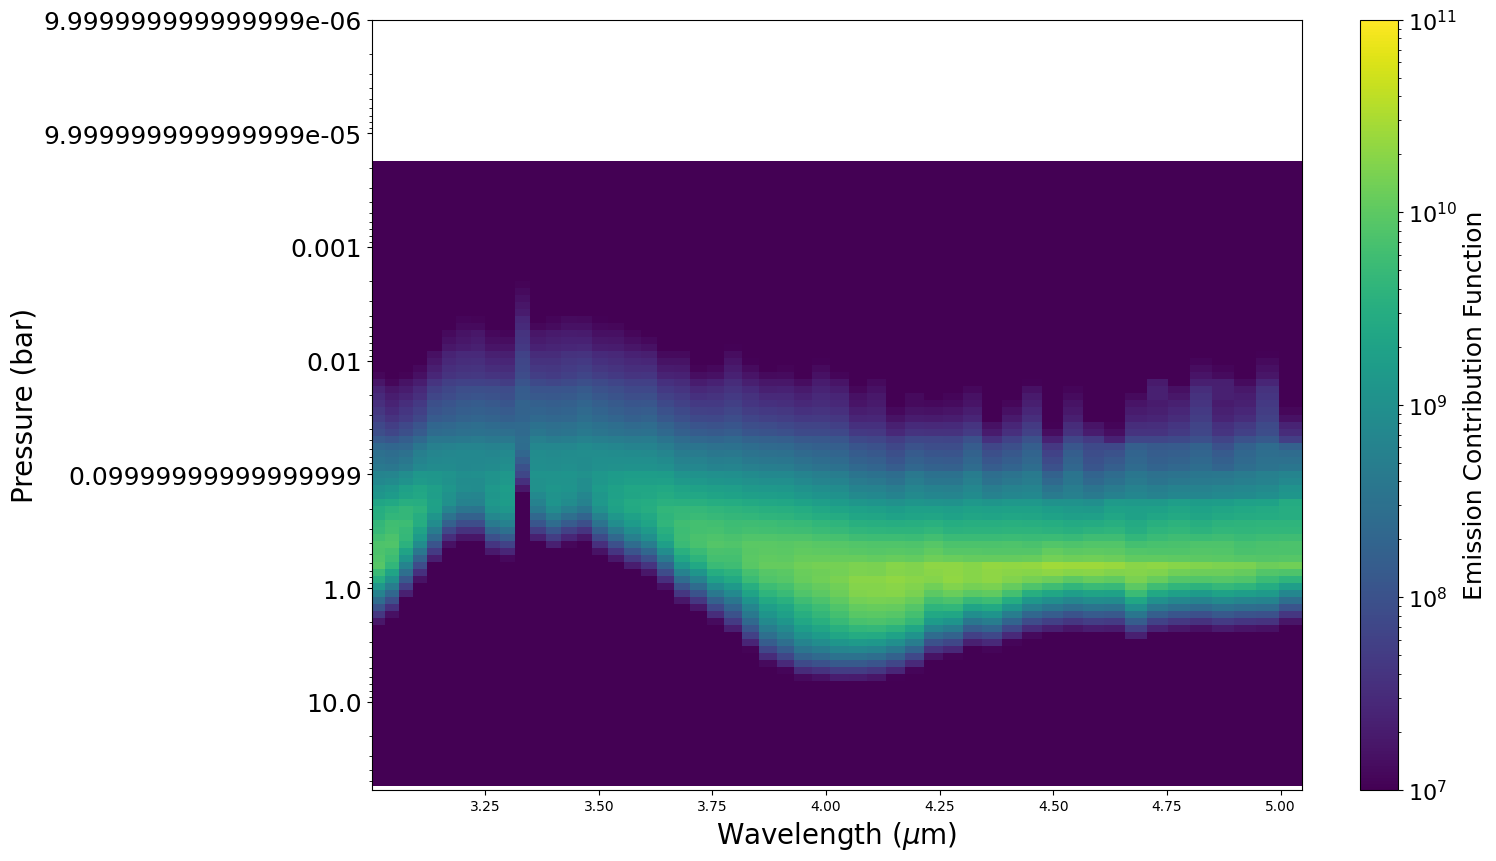

In [9]:
fig, ax, CF = jpi.thermal_contribution(df['full_output'], norm=jpi.colors.LogNorm(vmin=1e7, vmax=1e11))